![nn](img/durg-dataset-cover.jpg)

## [머신러닝] Kaggle - 약물 투입 결과 예측 (분류, Classification)
 - 분석 결과 파일 : ml_classification/drug_classify.ipynb <br><br>

> #### Drug Classification  <br>
- 데이터는 다음의 링크에서 확인할 수 있습니다. → [링크](https://www.kaggle.com/datasets/prathamtripathi/drug-classification) <br><br>

> #### 다음 6개의 변수를 가지고 있으며 `Drug`를 분류하는 것이 목적입니다.<br>
- `Age` : 나이<br>
- `Sex` : 성별<br>
- `BP` : 혈압 수준 (Blood Pressure Levels)<br>
- `Cholesterol` : 콜레스테롤 수준<br>
- `Na_to_K` : 체내 나트륨과 칼륨 비율 (전해질 균형, Na to Potassium Ration)<br>
- `Drug` : 약물 타입 <br><br>

> #### 사용한 Model (1개):
- 앙상블모델 : RandomForestRegressor <br><br>

> #### 성능 평가 지표 :
- accuracy, precision, recall, f1-score

> #### 결과 요약
- 분류 성능<br>
-                 precision    recall  f1-score   support
           0          1.00      1.00      1.00        27
           1          1.00      1.00      1.00         7
           2          1.00      1.00      1.00         4
           3          1.00      0.75      0.86         4
           4          0.95      1.00      0.97        18
         accuracy                         0.98        60
         macro avg    0.99      0.95      0.97        60
         weighted avg 0.98      0.98      0.98        60


> 전체 데이터 200건 중 160건 (Training, 학습용 데이터, 70%) | 60건 (Test 테스트용 데이터, 30%) 으로 분할 후 진행 <br>
  - 테스트용 데이터로 확인한 성능은 3(drugC)을 4(drugX)로 잘못 분류한 1건 외로는 모두(59건) 정확하게 분류했습니다. <br>

> [Label Encoding] Drug : DrugY(0), drugA(1), drugB(2), drugC(3), drugX(4) <br>
 - 분류 클래스인 Drug의 각 개수는 DrugY(45.5%, 91개), drugX(27%, 54개), drugA(11.5%, 23개), drugB와 drugC는 각 8%(16개) <br>
 - drugC(3)를 drugX(4)로 잘못 예측한 1건 외로는 정확하게 예측했습니다. (Accuracy : 0.98) <br>

> 왜 1건을 잘못 예측했을까?
 - 예측이 잘된 Drug 0, 1, 2는 비교적 특징이 명확한 편이라 학습의 경우의 수(?)가 많지 않았습니다. <br>
   Ex. 같은 Sex, BP, Cholesterol이라도 Na_to_K 수치가 일정부분 이상에 해당되는 등. <br>
 - 유사한 부분을 특징으로 잡고 분류하므로 그 영향이 있는 것으로 추정됩니다. <br>
 - 이 데이터의 경우 특징을 잡을 컬럼 수가 많지 않고, <br>
   잘못 예측한 Drug3은 데이터가 다른 클래스에 비해 적은데 특징의 경우의 수가 많은 게 영향이 있는 것으로 추정됩니다.

# 1. 라이브러리 import & 데이터 Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# 2. EDA (Exploratory Data Analysis)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
# 모든 변수 결측치 확인
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [5]:
# object 타입 value 개수
print(df['Sex'].value_counts())
print(df['BP'].value_counts())
print(df['Cholesterol'].value_counts())

Sex
M    104
F     96
Name: count, dtype: int64
BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64
Cholesterol
HIGH      103
NORMAL     97
Name: count, dtype: int64


In [6]:
# 분류 클래스(target) 'Drug' value 개수
df['Drug'].value_counts()

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

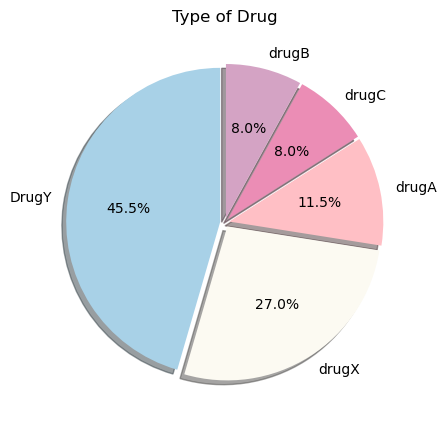

In [7]:
# Pie Chart로 확인
plt.figure(figsize=(5, 5))
explode = [0.03, 0.03, 0.03, 0.03, 0.03]
colors = ['#A8D1E7', '#FCFAF2', '#FFBFC5', '#EB8DB5', '#D4A3C4']

plt.pie(df["Drug"].value_counts(), labels=df["Drug"].value_counts().index, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors, shadow=True)
plt.title('Type of Drug')
plt.show()

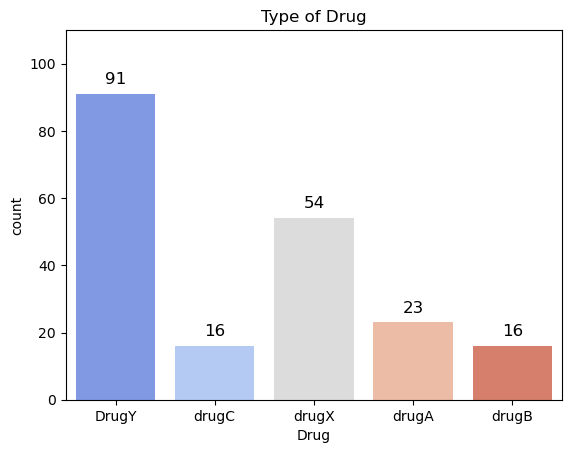

In [8]:
# bar chart로 확인
palette1 = sns.color_palette('coolwarm', 5)
ax = sns.countplot(x=df['Drug'], palette=palette1)
plt.title('Type of Drug')

# countplot에 값 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, round(height), ha = 'center', size = 12)
ax.set_ylim(0, 110)
plt.show()

In [9]:
# 데이터 전체 통계
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


## 3. 데이터 전처리

In [10]:
# 라벨인코딩 (object -> int형 변환)
cols = df.select_dtypes(include=object).columns
LabelEncoder = LabelEncoder()
for col in cols:
    df[col] = LabelEncoder.fit_transform(df[col])
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0


Label Encoding 결과
 - DrugY (0)   91
 - drugA (1)   23
 - drugB (2)   16
 - drugC (3)   16
 - drugX (4)   54

array([[<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'BP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'Na_to_K'}>,
        <Axes: title={'center': 'Drug'}>]], dtype=object)

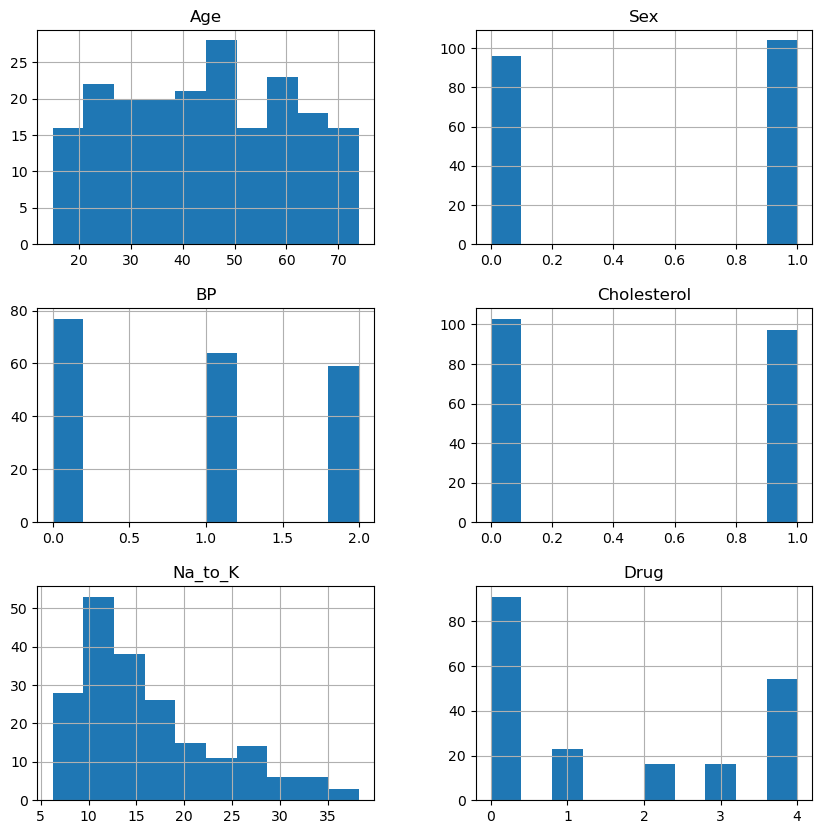

In [11]:
df.hist(figsize=(10,10))

In [12]:
# 변수 간 상관관계 확인
df.corr()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
Age,1.000000,0.102027,0.054212,-0.068234,-0.063119,0.041856
Sex,0.102027,1.000000,-0.007814,-0.008811,-0.125008,0.018239
BP,0.054212,-0.007814,1.000000,-0.137552,-0.149312,0.419397
Cholesterol,-0.068234,-0.008811,-0.137552,1.000000,0.010000,0.048415
Na_to_K,-0.063119,-0.125008,-0.149312,0.010000,1.000000,-0.689051
Drug,0.041856,0.018239,0.419397,0.048415,-0.689051,1.000000


<Axes: >

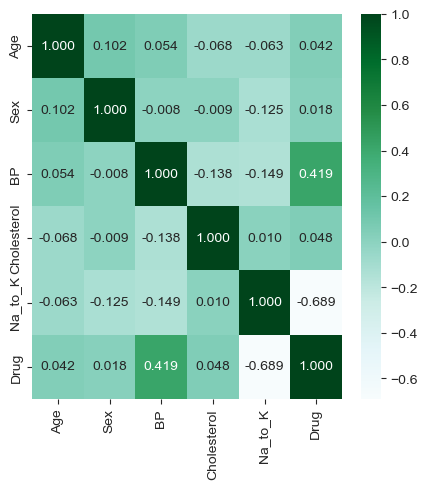

In [13]:
# Heatmap으로 상관관계 확인
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(df.corr(), annot=True, fmt='.3f', cmap='BuGn')

## 4. 모델 학습 & 성능 평가

In [14]:
# 데이터 Train, Test 나누기
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Drug', axis=1), df['Drug'], test_size=0.3, random_state=1234
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(140, 5) (60, 5) (140,) (60,)


In [15]:
X_train.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K
97,56,0,0,0,25.395
66,29,1,0,0,12.856
122,34,1,2,0,22.456


In [16]:
y_train.head(3)

97     0
66     1
122    0
Name: Drug, dtype: int64

In [17]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 140 entries, 97 to 47
Series name: Drug
Non-Null Count  Dtype
--------------  -----
140 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [18]:
# 모델 학습
model = RandomForestClassifier(random_state=1234, max_depth=4, n_estimators=800)
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

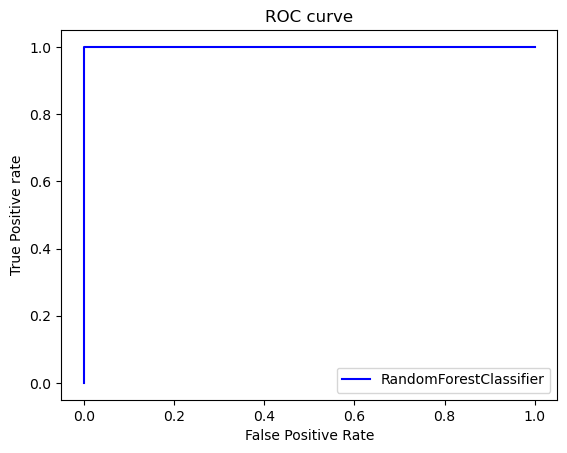

In [28]:
# AUC 면적 구하기
fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1], pos_label=1)
plt.style.use('default')
plt.plot(fpr, tpr, color='blue', label='RandomForestClassifier')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=400)
plt.show()

In [21]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       1.00      0.75      0.86         4
           4       0.95      1.00      0.97        18

    accuracy                           0.98        60
   macro avg       0.99      0.95      0.97        60
weighted avg       0.98      0.98      0.98        60



In [22]:
mask = np.zeros_like(confusion_matrix(y_test , pred))
mask[np.triu_indices_from(mask)] = True

<Axes: >

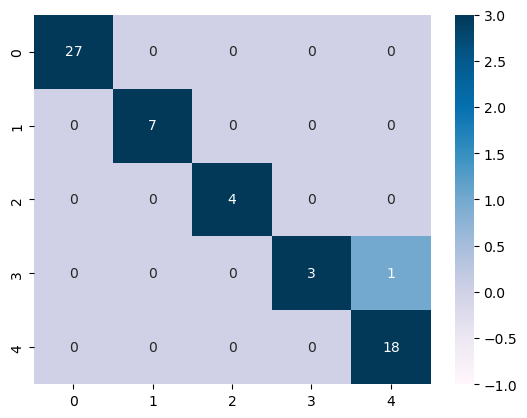

In [23]:
sns.heatmap(confusion_matrix(y_test , pred), annot=True, cmap='PuBu', vmin=-1, vmax=3, cbar=True)

# 5. 잘못 분류된 케이스 확인

In [80]:
check = pd.DataFrame(
    {
        'y':y_test,
        'pred':pred
    }
)
check['result'] = check['pred'] == check['y']
dataFilter = check['result'] == False
ft_check = check[dataFilter]
ft_check

,y,pred,result
193,3,4,False


In [82]:
# Drug3 확인
drug3 = df['Drug'] == 3
drug3_df = df[drug3]
drug3_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
7,41,1,1,0,11.037,3
10,47,0,1,0,11.767,3
18,23,1,1,0,7.298,3
47,68,1,1,0,10.291,3
55,26,0,1,0,14.160,3
82,32,0,1,0,9.712,3
84,47,0,1,0,10.067,3
102,28,0,1,0,13.127,3


In [ ]:
# Drug4만 확인
drug4 = df['Drug'] == 4
drug4_df = df[drug4]
drug4_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
3,28,0,2,0,7.798,4
5,22,0,2,0,8.607,4
14,50,0,2,0,12.703,4
16,69,1,1,1,11.455,4
27,49,0,2,1,9.381,4
30,18,0,2,1,8.750,4
32,49,1,1,1,11.014,4
34,53,1,2,0,14.133,4
35,46,1,2,1,7.285,4
37,39,1,1,1,13.938,4


---

In [87]:
# Drug2 확인 (Drug3과 데이터 개수가 같음)
drug2 = df['Drug'] == 2
drug2_df = df[drug2]
drug2_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
31,74,1,0,0,9.567,2
41,58,0,0,1,14.239,2
54,68,0,0,1,10.189,2
56,65,1,0,1,11.340,2
64,60,0,0,0,13.303,2
70,70,1,0,0,13.967,2
80,60,1,0,0,13.934,2
85,59,1,0,0,13.935,2
108,72,1,0,1,9.677,2
124,53,0,0,1,12.495,2


In [88]:
# Drug1 확인 (데이터 수가 많지는 않지만 비교적 단순한 패턴을 가짐)
drug1 = df['Drug'] == 1
drug1_df = df[drug1]
drug1_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
17,43,1,0,0,13.972,1
36,32,1,0,1,9.445,1
46,37,0,0,0,13.091,1
61,24,1,0,1,9.475,1
66,29,1,0,0,12.856,1
76,36,0,0,0,11.198,1
78,19,0,0,0,13.313,1
83,38,0,0,1,11.326,1
100,31,1,0,1,11.871,1
101,45,0,0,0,12.854,1


In [90]:
# Drug0 확인 (데이터 수가 가장 많고, 특히 Na_to_K 수치가 타Class 보다 높은 편에 속함)
drug0 = df['Drug'] == 0
drug0_df = df[drug0]
drug0_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
4,61,0,1,0,18.043,0
6,49,0,2,0,16.275,0
8,60,1,2,0,15.171,0
9,43,1,1,1,19.368,0
...,...,...,...,...,...,...
188,65,1,0,1,34.997,0
189,64,1,0,1,20.932,0
190,58,1,0,0,18.991,0
192,72,1,1,0,16.310,0
